<a href="https://colab.research.google.com/github/GalamPrathibha/Vehicle_direction_prediction/blob/main/Vehicle_direction_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib  # NEW: For saving/loading models

from collections import Counter
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from skimage.feature import hog
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier


In [2]:
#Feature Extraction
def extract_features(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (256, 256))
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Color histogram
    hist_color = cv2.calcHist([img], [0, 1, 2], None, [8,8,8], [0,256, 0,256, 0,256])
    hist_color = cv2.normalize(hist_color, hist_color).flatten()

    # HOG features
    hog_feat = hog(img_gray, pixels_per_cell=(16, 16), cells_per_block=(2, 2), feature_vector=True)

    # Texture
    mean_val = np.mean(img_gray)
    std_val = np.std(img_gray)

    # Shape
    edges = cv2.Canny(img_gray, 100, 200)
    edge_count = np.sum(edges > 0)

    # ORB Keypoints
    orb = cv2.ORB_create()
    keypoints, descriptors = orb.detectAndCompute(img_gray, None)
    if descriptors is not None:
        orb_features = descriptors.flatten()
        orb_features = orb_features[:256] if len(orb_features) >= 256 else np.pad(orb_features, (0, 256 - len(orb_features)))
    else:
        orb_features = np.zeros(256)

    return np.hstack([hist_color, hog_feat, mean_val, std_val, edge_count, orb_features])


In [3]:
#Load Dataset & Plot Class Distribution
def load_dataset(directory):
    features = []
    labels = []
    for label in os.listdir(directory):
        label_folder = os.path.join(directory, label)
        if os.path.isdir(label_folder):
            for img_file in os.listdir(label_folder):
                img_path = os.path.join(label_folder, img_file)
                try:
                    feat = extract_features(img_path)
                    features.append(feat)
                    labels.append(label)
                except:
                    pass
    return np.array(features), np.array(labels)

def plot_class_distribution(labels, title):
    counts = Counter(labels)
    plt.bar(counts.keys(), counts.values(), color='skyblue')
    plt.title(title)
    plt.show()


In [4]:
# Unzip (if running in Colab)
!unzip /content/handgestures1\ \(3\).zip

Archive:  /content/handgestures1 (3).zip
   creating: handgestures1/
   creating: handgestures1/back/
  inflating: handgestures1/back/up_000.png  
  inflating: handgestures1/back/up_001.png  
  inflating: handgestures1/back/up_002.png  
  inflating: handgestures1/back/up_003.png  
  inflating: handgestures1/back/up_004.png  
  inflating: handgestures1/back/up_005.png  
  inflating: handgestures1/back/up_006.png  
  inflating: handgestures1/back/up_007.png  
  inflating: handgestures1/back/up_008.png  
  inflating: handgestures1/back/up_009.png  
  inflating: handgestures1/back/up_010.png  
  inflating: handgestures1/back/up_011.png  
  inflating: handgestures1/back/up_012.png  
  inflating: handgestures1/back/up_013.png  
  inflating: handgestures1/back/up_014.png  
  inflating: handgestures1/back/up_015.png  
  inflating: handgestures1/back/up_016.png  
  inflating: handgestures1/back/up_017.png  
  inflating: handgestures1/back/up_018.png  
  inflating: handgestures1/back/up_019.png 

In [5]:
!unzip /content/vehicledata3.zip

Archive:  /content/vehicledata3.zip
   creating: vehicledata2/
   creating: vehicledata2/back/
  inflating: vehicledata2/back/ambulance1.jpg  
  inflating: vehicledata2/back/ambulance2.jpg  
  inflating: vehicledata2/back/ambulance3.jpg  
  inflating: vehicledata2/back/ambulance4.jpg  
  inflating: vehicledata2/back/ambulance5.jpg  
  inflating: vehicledata2/back/ambulance6.jpg  
  inflating: vehicledata2/back/ambulance7.jpg  
  inflating: vehicledata2/back/boat1.jpg  
  inflating: vehicledata2/back/boat2.jpg  
  inflating: vehicledata2/back/boat3.jpg  
  inflating: vehicledata2/back/boat4.jpg  
  inflating: vehicledata2/back/boat5.jpg  
  inflating: vehicledata2/back/boat6.jpg  
  inflating: vehicledata2/back/boat7.jpg  
  inflating: vehicledata2/back/car1.jpg  
  inflating: vehicledata2/back/car10.jpg  
  inflating: vehicledata2/back/car2.jpg  
  inflating: vehicledata2/back/car3.jpg  
  inflating: vehicledata2/back/car4.jpg  
  inflating: vehicledata2/back/car5.jpg  
  inflating: ve

In [6]:
# Load Datasets
hand_features, hand_labels = load_dataset('/content/handgestures1')
vehicle_features, vehicle_labels = load_dataset('/content/vehicledata2')

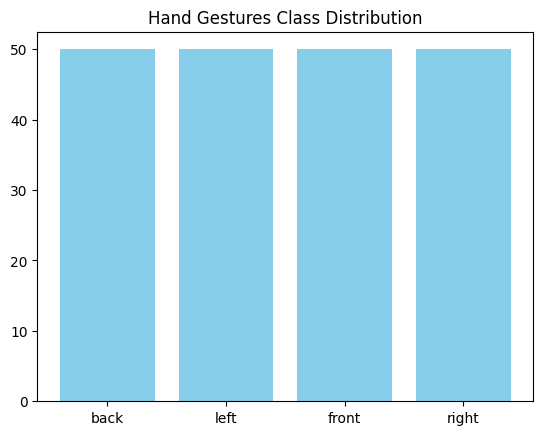

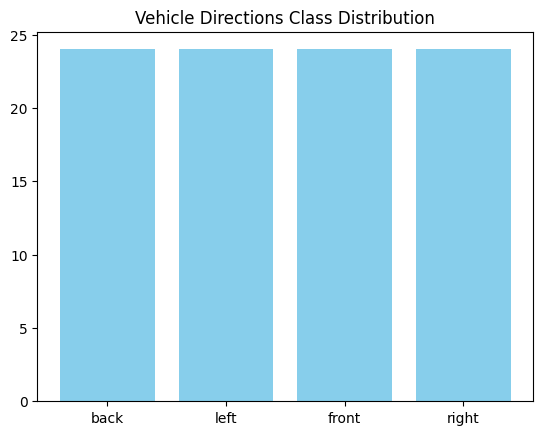

In [7]:
# Visualize
plot_class_distribution(hand_labels, 'Hand Gestures Class Distribution')
plot_class_distribution(vehicle_labels, 'Vehicle Directions Class Distribution')

In [8]:
# Encode Labels
le_hand = LabelEncoder()
hand_labels_encoded = le_hand.fit_transform(hand_labels)

le_vehicle = LabelEncoder()
vehicle_labels_encoded = le_vehicle.fit_transform(vehicle_labels)

# Scale Features
scaler_hand = StandardScaler()
hand_features_scaled = scaler_hand.fit_transform(hand_features)

scaler_vehicle = StandardScaler()
vehicle_features_scaled = scaler_vehicle.fit_transform(vehicle_features)


In [9]:
# Train/Test Split
# Hand
X_train_hand, X_test_hand, y_train_hand, y_test_hand = train_test_split(
    hand_features_scaled, hand_labels_encoded, test_size=0.2, random_state=42, stratify=hand_labels_encoded)

# Vehicle
X_train_vehicle, X_test_vehicle, y_train_vehicle, y_test_vehicle = train_test_split(
    vehicle_features_scaled, vehicle_labels_encoded, test_size=0.2, random_state=42, stratify=vehicle_labels_encoded)


In [10]:
# Hyperparameter Tuning + Train Improved SVM
# Hyperparameters to try
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.01, 0.001],
    'kernel': ['rbf'],
    'class_weight': ['balanced']
}

# Hand Model
grid_hand = GridSearchCV(SVC(probability=True), param_grid, cv=5)
grid_hand.fit(X_train_hand, y_train_hand)
hand_model_best = grid_hand.best_estimator_

param_grid_vehicle = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.001, 0.0001],
    'kernel': ['rbf', 'poly'],  # Try RBF and Polynomial
    'degree': [2, 3],           # For poly kernel
    'class_weight': [None]
}

grid_vehicle = GridSearchCV(SVC(probability=True), param_grid_vehicle, cv=5, n_jobs=-1)
grid_vehicle.fit(X_train_vehicle, y_train_vehicle)

vehicle_model_best = grid_vehicle.best_estimator_

print("✅ Models tuned and trained!")


✅ Models tuned and trained!


In [11]:
print("Best Hand Model Params:", grid_hand.best_params_)
print("Best Vehicle Model Params:", grid_vehicle.best_params_)


Best Hand Model Params: {'C': 0.1, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'}
Best Vehicle Model Params: {'C': 10, 'class_weight': None, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}



Hand Gesture Classification Report:
              precision    recall  f1-score   support

        back       1.00      1.00      1.00        10
       front       1.00      1.00      1.00        10
        left       1.00      1.00      1.00        10
       right       1.00      1.00      1.00        10

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

Accuracy: 100.00%


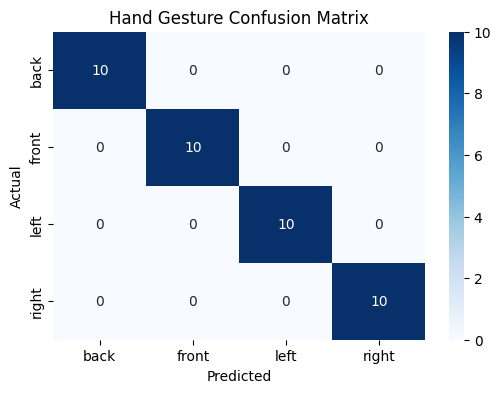


Vehicle Direction (Best SVM) Classification Report:
              precision    recall  f1-score   support

        back       0.27      0.60      0.38         5
       front       0.25      0.20      0.22         5
        left       1.00      0.20      0.33         5
       right       0.25      0.20      0.22         5

    accuracy                           0.30        20
   macro avg       0.44      0.30      0.29        20
weighted avg       0.44      0.30      0.29        20

Accuracy: 30.00%


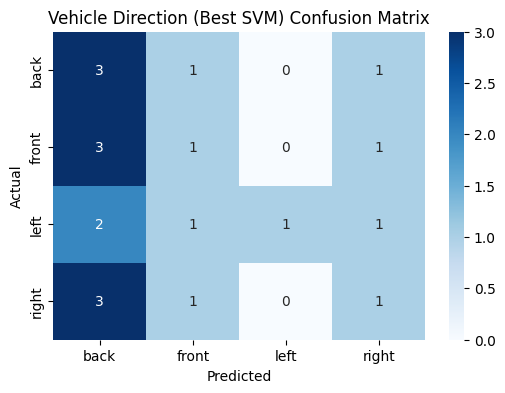


Vehicle Direction (Ensemble Boosted) Classification Report:
              precision    recall  f1-score   support

        back       0.29      0.40      0.33         5
       front       0.50      0.40      0.44         5
        left       0.75      0.60      0.67         5
       right       0.40      0.40      0.40         5

    accuracy                           0.45        20
   macro avg       0.48      0.45      0.46        20
weighted avg       0.48      0.45      0.46        20

Accuracy: 45.00%


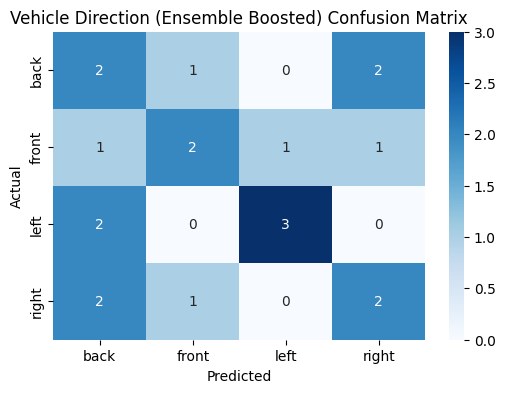


Hand Gesture Cross-Validation Accuracy: 100.00%
Vehicle Direction Cross-Validation Accuracy: 37.47%


In [12]:
# Evaluation Function
def evaluate_model(model, X_test, y_test, label_encoder, title):
    y_pred = model.predict(X_test)
    print(f"\n{title} Classification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc * 100:.2f}%")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title(f"{title} Confusion Matrix")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
# Evaluate Tuned Models
evaluate_model(hand_model_best, X_test_hand, y_test_hand, le_hand, "Hand Gesture")
evaluate_model(vehicle_model_best, X_test_vehicle, y_test_vehicle, le_vehicle, "Vehicle Direction (Best SVM)")
# Random Forest
rf_vehicle = RandomForestClassifier(n_estimators=100, random_state=42)

# Ensemble: SVM + Random Forest
vehicle_ensemble = VotingClassifier(estimators=[
    ('svm', vehicle_model_best),
    ('rf', rf_vehicle)
], voting='soft')

vehicle_ensemble.fit(X_train_vehicle, y_train_vehicle)

# Evaluate Ensemble Boosted
evaluate_model(vehicle_ensemble, X_test_vehicle, y_test_vehicle, le_vehicle, "Vehicle Direction (Ensemble Boosted)")

# Cross-validation
cv_scores_hand = cross_val_score(hand_model_best, hand_features_scaled, hand_labels_encoded, cv=5)
cv_scores_vehicle = cross_val_score(vehicle_model_best, vehicle_features_scaled, vehicle_labels_encoded, cv=5)

print(f"\nHand Gesture Cross-Validation Accuracy: {cv_scores_hand.mean() * 100:.2f}%")
print(f"Vehicle Direction Cross-Validation Accuracy: {cv_scores_vehicle.mean() * 100:.2f}%")


In [13]:
# Save Tuned Models
joblib.dump(hand_model_best, "hand_gesture_model.pkl")
joblib.dump(vehicle_model_best, "vehicle_direction_model.pkl")

# Save Scalers and Label Encoders too
joblib.dump(scaler_hand, "scaler_hand.pkl")
joblib.dump(scaler_vehicle, "scaler_vehicle.pkl")

joblib.dump(le_hand, "label_encoder_hand.pkl")

joblib.dump(le_vehicle, "label_encoder_vehicle.pkl")

print("✅ Models, scalers, and encoders saved successfully!")


✅ Models, scalers, and encoders saved successfully!


In [14]:
# Load Models
hand_model_loaded = joblib.load("hand_gesture_model.pkl")
vehicle_model_loaded = joblib.load("vehicle_direction_model.pkl")

# Load Scalers and Label Encoders
scaler_hand_loaded = joblib.load("scaler_hand.pkl")
scaler_vehicle_loaded = joblib.load("scaler_vehicle.pkl")

le_hand_loaded = joblib.load("label_encoder_hand.pkl")
le_vehicle_loaded = joblib.load("label_encoder_vehicle.pkl")

print("✅ Models and utilities loaded successfully!")


✅ Models and utilities loaded successfully!


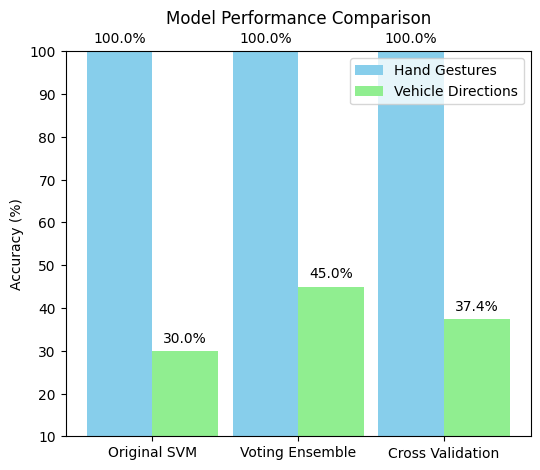

In [24]:
#1) (Compare Old SVM vs Boosted SVM vs Ensemble Voting Classifier)
import numpy as np
import matplotlib.pyplot as plt

# Example scores (replace with your actual test accuracy %)
scores_hand = {
    'Original SVM': 100.0,
    'Voting Ensemble': 100.0,
    'Cross Validation': 100.0

}

scores_vehicle = {
    'Original SVM': 30.00,
    'Voting Ensemble': 45.0,
    'Cross Validation': 37.4

}

# Plot
labels = list(scores_hand.keys())
hand_scores = list(scores_hand.values())
vehicle_scores = list(scores_vehicle.values())

x = np.arange(len(labels))
width = 0.45

fig, ax = plt.subplots(figsize=(6,5))
rects1 = ax.bar(x - width/2, hand_scores, width, label='Hand Gestures', color='skyblue')
rects2 = ax.bar(x + width/2, vehicle_scores, width, label='Vehicle Directions', color='lightgreen')

# Labels & Title
ax.set_ylabel('Accuracy (%)')
width=0.25
ax.set_title('Model Performance Comparison',pad=20)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Annotate bars
for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate(f'{height:.1f}%',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 4),  # Offset
                textcoords="offset points",
                ha='center', va='bottom')

plt.ylim(10, 100)
plt.show()


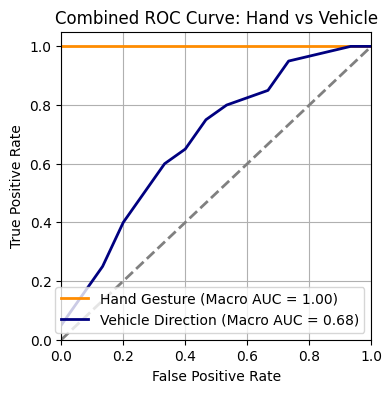

In [25]:
#roc curve for both handgestures and vehicledata
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import LabelEncoder
import numpy as np

def compute_macro_roc(model, X_test, y_test, label_encoder):
    # Binarize output
    y_test_bin = label_binarize(y_test, classes=range(len(label_encoder.classes_)))
    y_score = model.predict_proba(X_test)
    n_classes = y_test_bin.shape[1]

    # Compute ROC curve and area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute macro-average ROC curve and AUC
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes
    macro_auc = auc(all_fpr, mean_tpr)
    return all_fpr, mean_tpr, macro_auc

# Compute for Hand
fpr_hand, tpr_hand, auc_hand = compute_macro_roc(hand_model_best, X_test_hand, y_test_hand, le_hand)

# Compute for Vehicle
fpr_vehicle, tpr_vehicle, auc_vehicle = compute_macro_roc(vehicle_model_best, X_test_vehicle, y_test_vehicle, le_vehicle)

# Plot Combined ROC
plt.figure(figsize=(4,4))
plt.plot(fpr_hand, tpr_hand, color='darkorange', lw=2, label=f'Hand Gesture (Macro AUC = {auc_hand:.2f})')
plt.plot(fpr_vehicle, tpr_vehicle, color='navy', lw=2, label=f'Vehicle Direction (Macro AUC = {auc_vehicle:.2f})')

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Combined ROC Curve: Hand vs Vehicle')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [26]:
#Prediction Function
def predict_direction_ml(model, scaler, le, img_path):
    feat = extract_features(img_path)
    feat_scaled = scaler.transform([feat])
    pred = model.predict(feat_scaled)
    return le.inverse_transform(pred)[0]



👉 Hand direction predicted: left
🚗 Vehicle direction predicted: left
✅ Both are pointing in the SAME direction!


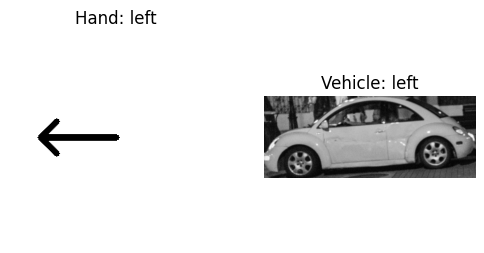

In [31]:
#Test Matching (with Loaded Models)
hand_img_path = '/content/handgestures1/left/left_003.png'
vehicle_img_path = '/content/vehicledata2/left/car8.jpg' # Verify path!

# Check if the file exists
if not os.path.exists(vehicle_img_path):
    print(f"Error: Image file not found at {vehicle_img_path}")
else:
    hand_pred_loaded = predict_direction_ml(hand_model_loaded, scaler_hand_loaded, le_hand_loaded, hand_img_path)
    vehicle_pred_loaded = predict_direction_ml(vehicle_model_loaded, scaler_vehicle_loaded, le_vehicle_loaded, vehicle_img_path)

    print(f"\n👉 Hand direction predicted: {hand_pred_loaded}")
    print(f"🚗 Vehicle direction predicted: {vehicle_pred_loaded}")

    if hand_pred_loaded == vehicle_pred_loaded:
        print("✅ Both are pointing in the SAME direction!")
    else:
        print("❌ Directions DO NOT match!")

#Display Matched Images
def show_images(img1_path, img2_path, label1, label2):
    img1 = cv2.imread(img1_path)
    img2 = cv2.imread(img2_path)

    plt.figure(figsize=(6,4))
    plt.subplot(1,2,1)
    plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
    plt.title(f"Hand: {label1}")
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
    plt.title(f"Vehicle: {label2}")
    plt.axis('off')

    plt.show()

# Show Matched Images
show_images(hand_img_path, vehicle_img_path, hand_pred_loaded, vehicle_pred_loaded)

